In [14]:
%load_ext autoreload
%autoreload 2

import fitz
import glob
import json
from pathlib import Path
import pandas as pd
import os
import sys 

base_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_path)
from evaluation.datasets import TableDataset
from evaluation.table_evaluator import TableEvaluator, perfect_match
from evaluation.utils import parse_table_csv, load_pickle
from meri.transformation.elements.table import Table as MeriTable
from meri.utils import pdf_to_im
from typing import List



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
annotations_path = os.path.join(base_path,'data/table_extraction/annotations')
pdfs_path = os.path.join(base_path,'data/table_extraction/pdf')

res_dir = os.path.join(base_path, 'results')

Sanity check that cropped tables are correct

[['Materials', ''], ['Product wetted steel parts:', 'W. 1.4404 (316L)'], ['Other steel parts:', 'Stainless steel'], ['Inside surface finish:', 'Standard blasted'], ['Product wetted elastomers:', 'EPDM'], ['Rotary seal face:', 'Carbon'], ['Stationary seal face:', 'Silicon Carbide']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 1}


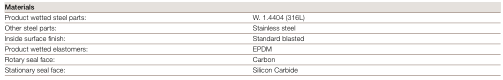

[['Motor'], ['Foot-flanged motor according to the IEC metric standard, 2 poles = 3000/3600 rpm at 50/60 Hz, 4 poles = 1500/1800 rpm at 50/60 Hz, IP 55 (with drain hole with labyrinth plug), insulation class F.']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 2}


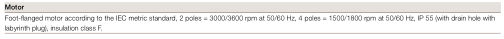

[['Motor sizes', ''], ['50Hz:', '0.75 - 110 kW'], ['60Hz:', '0.75 - 110 kW']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 3}


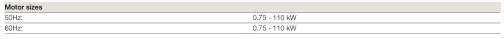

[['Min/max motor speed', ''], ['2 poles: 0.75 - 45 kW:', '900 - 4000 rpm'], ['2 poles: 55 - 110 kW:', '900 - 3600 rpm'], ['4 poles: 0.75 - 75 kW:', '900 - 2200 rpm']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 4}


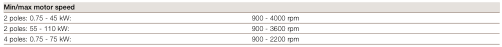

[['Warranty', ''], ['Extended 3-years warranty on LKH pumps. The warranty covers all non wear parts on the condition that genuine Alfa Laval Spare Parts are used.', '']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 5}


[['Max inlet pressure', ''], ['LKH-5:', '600 kPa (6 bar)'], ['LKH-10 - 70:', '1000kPa (10 bar)'], ['LKH-70, 60Hz:', '500kPa (5 bar)'], ['LKH-85 - 90:', '500kPa (5 bar)']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 6}


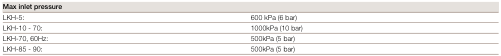

[['Temperature', ''], ['Temperature range:', '-10°C to +140°C (EPDM)'], ['Flush media:', 'Max 70°C'], ['Flush housing sterilization (pump not in operation):', 'Max 125°C']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 7}


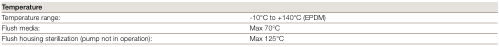

[['Flushed shaft seal', ''], ['Water pressure inlet:', 'Max. 1 bar'], ['Water consumption:', '0.25 - 0.5 l/min']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 8}


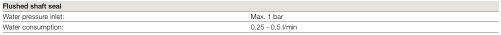

[['Double mechanical shaft seal', ''], ['Water pressure inlet, LKH-5 to -60:', 'Max. 500 kPa (5 bar)'], ['Water pressure inlet, LKH-70 to -90:', 'Max. 300 kPa (3 bar)'], ['Water consumption:', '0.25 - 0.5 l/min']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 9}


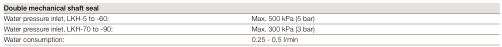

[['Connections for flushed and double mechanical shaft seal', ''], ['LKH-5 - 70, LKH-90:', '1/8" G'], ['LKH-85:', 'Ø6 tube']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 2, 'table_id': 10}


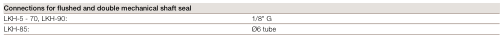

[['Pump Model', 'LKH-5', 'LKH-10', 'LKH-15', 'LKH-20', 'LKH-25', 'LKH-35', 'LKH-40', 'LKH-45', 'LKH-50', 'LKH-60', 'LKH-70', 'LKH-85', 'LKH-90'], ['A', '158', '142', '166', '180', '193', '193', '212', '193', '205', '261', '254', '229', '310'], ['B', '70', '87', '66', '88', '106', '119', '126', '97', '118', '102', '147', '220', '250'], ['C', '22', '23', '43', '27', '32', '23', '28', '41', '35', '62', '25', '65', '65'], ['D', '189', '247', '247', '253', '303', '303', '329', '329', '329', '329', '408', '438', '504'], ['E', '42', '51', '87', '63', '69', '54', '64', '64', '77', '106', '76', '97', '95']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 3, 'table_id': 1}


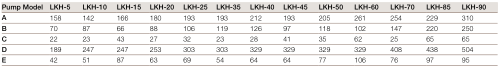

[['Motor IEC', 'IEC80', 'IEC90', 'IEC100', 'IEC112', 'IEC132', 'IEC160', 'IEC180', 'IEC200', 'IEC250', 'IEC280'], ['Motor kW', '0.75/1.1', '1.5/2.2', '3.0', '4.0', '5.5/7.5', '11/15/18.5', '22', '30/37/45', '55/75', '90/110'], ['F(max) 1', '262', '262', '282', '285', '304', '332', '352', '372', '446', '496'], ['G', '125', '157', '185', '198', '196', '262', '286', '399', '394', '584'], ['H', '250', '288', '325', '359', '383', '485', '533', '670', '738', '960'], ['I (LKH-5)', '400', '441', '-', '-', '-', '-', '-', '-', '-', '-'], ['I (LKH-10 to -60)', '-', '434', '516', '497', '597', '791', '842', '980', '-', '-'], ['I (LKH-70 to -90)', '-', '-', '-', '-', '-', '804', '855', '993', '1051', '1271']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 3, 'table_id': 2}


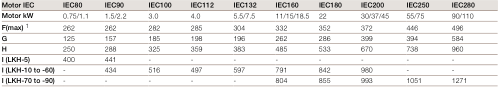

[['Pump Model', 'LKH-5', 'LKH-10', 'LKH-15', 'LKH-20', 'LKH-25', 'LKH-35', 'LKH-40', 'LKH-45', 'LKH-50', 'LKH-60', 'LKH-70', 'LKH-85', 'LKH-90'], ['Motor range (IEC)', 'IEC80-IEC90', 'IEC90-IEC160', 'IEC90-IEC160', 'IEC90-IEC160', 'IEC90-IEC200', 'IEC90-IEC180', 'IEC90-IEC200', 'IEC100-IEC180', 'IEC100-IEC200', 'IEC112-IEC200', 'IEC160-IEC250', 'IEC200-IEC280', 'IEC180-IEC250']]
{'file': 'Alfa Laval LKH.pdf', 'page_id': 3, 'table_id': 3}


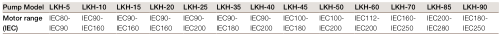

[['Pump Model', '', 'LKH-5', 'LKH-10 LKH-20 LKH-35', 'LKH-15 LKH-45 LKH-50 LKH-70', 'LKH-25', 'LKH-40', 'LKH-60', 'LKH-85 LKH-90'], ['Clamp ISO 2037', 'M1', '21', '21', '21', '21', '21', '21', '-'], ['', 'M2', '21', '21', '21', '21', '12', '21', '-'], ['Union ISO(IDF)', 'M1', '21', '21', '21', '21', '21', '21', '-'], ['', 'M2', '21', '21', '21', '21', '21', '21', '-'], ['Union DIN/ISO', 'M1', '22', '25', '30', '30', '30', '30', '-'], ['', 'M2', '22', '22', '30', '25', '27', '30', '-'], ['Union SMS', 'M1', '20', '24', '35', '24', '24', '35', '-'], ['', 'M2', '20', '20', '24', '24', '24', '35', '-'], ['Union (BS)RJT', 'M1', '27', '27', '32', '27', '27', '32', '-'], ['', 'M2', '27', '27', '27', '27', '22', '32', '-'], ['Union DS', 'M1', '20', '24', '24', '24', '24', '24', '-'], ['', 'M2', '20', '20', '24', '24', '21', '24', '-'], ['Union DIN/DIN', 'M1', '22', '25', '30', '30', '30', '30', '50'], ['', 'M2', '22', '22', '30', '25', '27', '30', '50'], ['Clamp ASME BPE', 'M1', '-', '-', '-', 

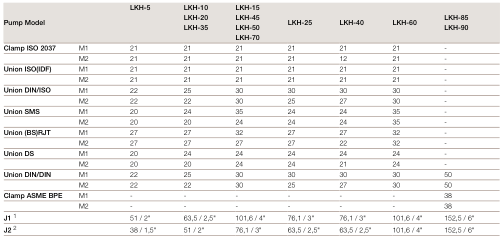

In [26]:
for fitz_page, plumber_page, bbox, table,ref in TableDataset(annotations_path, pdfs_path, ann_json_name='annotation.json'):
    print(table)
    print(ref)
    im = pdf_to_im(fitz_page, cropbbox=bbox)
    im.show()

In [37]:
load_pickle('/workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_5.pickle')

[[]]

Evaluate table extracion for LLM and PDFPlumber

In [20]:
ann_json = 'annotation.json' #'annotation_only_diff.json'

In [52]:
tableEvaluator = TableEvaluator(annotations_path, pdfs_path, 'pdfplumber', perfect_match, res_dir, ann_json)
plumber_overall_res, plumber_table_results = tableEvaluator.evaluate(existsOk=True)

14it [00:00, 98.13it/s]

Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_1.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_2.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_3.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_4.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_5.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_6.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_7.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_8.pickle
Loaded cached results from /workspaces/meri/results/table_extraction/pdfplumber/pred_Alfa Laval LKH_2_9.pickle
L

In [17]:
tableEvaluator = TableEvaluator(annotations_path, pdfs_path, 'llm', perfect_match, res_dir, ann_json_name='annotation_only_diff.json')
llm_overall_res, llm_table_results = tableEvaluator.evaluate()

TypeError: TableEvaluator.__init__() missing 1 required positional argument: 'res_dir'

In [50]:
plumber_overall_res

{'total_tables': 14,
 'total_cells': 439,
 'correct_cells': 192,
 'avg_acc': 0.6875493658388393,
 'acc': 0.43735763097949887,
 'incorrect_matches': [{'gt': 'Foot-flanged motor according to the IEC metric standard, 2 poles = 3000/3600 rpm at 50/60 Hz, 4 poles = 1500/1800 rpm at 50/60 Hz, IP 55 (with drain hole with labyrinth plug), insulation class F.',
   'pred': 'Foot-flanged motor according to the IEC metric standard, 2 poles = 3000/3600 rpm at 50/60 Hz, 4 poles = 1500/1800 rpm at 50/60 Hz, IP 55 (with drain hole with'},
  {'gt': 'LKH-5:', 'pred': ' '},
  {'gt': '600 kPa (6 bar)', 'pred': 'note: cell not detected'},
  {'gt': 'LKH-10 - 70:', 'pred': 'LKH-5:'},
  {'gt': '1000kPa (10 bar)', 'pred': '600 kPa (6 bar)'},
  {'gt': 'LKH-70, 60Hz:', 'pred': 'LKH-10 - 70:'},
  {'gt': '500kPa (5 bar)', 'pred': '1000kPa (10 bar)'},
  {'gt': 'LKH-85 - 90:', 'pred': 'LKH-70, 60Hz:'},
  {'gt': '262', 'pred': 'note: cell not detected'},
  {'gt': '262', 'pred': 'note: cell not detected'},
  {'gt': '2

In [35]:
llm_overall_res

{'total_tables': 3,
 'total_cells': 22,
 'correct_cells': 21,
 'avg_acc': 0.8333333333333333,
 'acc': 0.9545454545454546,
 'incorrect_matches': []}

Tests

In [34]:
pd.read_csv("/workspaces/meri/data/table_extraction/annotations/Alfa Laval LKH_3_1.csv", sep=';', header=None)

,0,1,2,3,4,5,6,7,8,9,10
0,Motor IEC,IEC80,IEC90,IEC100,IEC112,IEC132,IEC160,IEC180,IEC200,IEC250,IEC280
1,Motor kW,0.75/1.1,1.5/2.2,3.0,4.0,5.5/7.5,11/15/18.5,22,30/37/45,55/75,90/110
2,F(max) 1,262,262,282,285,304,332,352,372,446,496
3,G,125,157,185,198,196,262,286,399,394,584
4,H,250,288,325,359,383,485,533,670,738,960
5,I (LKH-5),400,441,-,-,-,-,-,-,-,-
6,I (LKH-10 to -60),-,434,516,497,597,791,842,980,-,-
7,I (LKH-70 to -90),-,-,-,-,-,804,855,993,1051,1271


In [19]:
x = 'first sec'

In [18]:
x.replace

'first\n sec'